# The Spectrum of Digitally Modulated Signals

We have described the construction of linearly modulated signals in the time-domain:
$$
s(t) = \sum_n s[n] \cdot p(t-nT).
$$

In this notebook, we compute the power-spectral density (PSD) of digitally modulated signals.

In [1]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

## PSD of digitally modulated signals

We have shown in class that the PSD $S(f)$ depends on:
* the average symbol energy $E_s$
* the symbol rate $R=1/T$
* and the pulse shape $p(t)$ (via it's Fourier transform $P(f)$)

The PSD of the modulated signal is given by:
$$
    S(f) = \frac{E_s}{T} |P(f)|^2. 
$$.

For many pulses, the PSD can be computed. In this notebook, we show how to compute it numerically from samples of the pulse shape $p(t)$

### Example: Rectangular Pulse

The rectangular pulse is defined as
$$
p_r(t) = \begin{cases}
    \frac{1}{\sqrt{T}} & \text{for $0\leq t < T$}\\
    0 & \text{else.}
\end{cases}
$$

The Fourier Transform for this pulse is well known:
$$
P_r(f) = \frac{1}{\sqrt{T}} \text{sinc}(\pi f T) e^{-j\pi f T}.
$$

Therefore, the power spectral density of a digitally modulated signal with rectangular pulse shaping is
$$
S(f) = \frac{E_s}{T} \frac{\text{sinc}^2(\pi f T)}{T^2}.
$$

We can compute this Fourier transform easily.

In [2]:
def FT_rect_pulse(ff, T=1):
    """compute the Fourier transform of a rectangular pulse"""

    return np.sinc(ff * T) / T  # np.sinc includes pi!

### Example: Half-Since Pulse

A smoother pulse is the half-sine pulse, defined as
$$
p_{hs}(t) = \begin{cases}
\sqrt{\frac{2}{T}} \sin(\pi t / T) & \text{for $0 \leq t < T$}\\
0 & \text{else.}
\end{cases}
$$

The Fourier transform of this pulse is also readily computed. It is equal to 
$$
P_{hs}(f) = \sqrt{\frac{2}{T}} \frac{2}{\pi} \frac{\cos(\pi fT)}{1-4(fT)^2}.
$$
The value of $P(f)$ when $4(fT)^2 = 1$, can be computed using L'Hospital's rule: $P_{hs}(\frac{1}{2T}) = \frac{1}{\sqrt{2T}}$.

Here is a function to compute $P_{hs}(f)$.

In [3]:
def FT_half_sine_pulse(ff, T=1):
    """Compute the Fourier transform of the half-sine pulse"""
    # find the frequencies that must be dealt with separately
    f_crit  = np.abs((np.abs(ff) - 0.5/T)) < 1e-8
    f_safe = ff[f_crit]
    ff[f_crit] = 0

    # compute all the non-critical values
    P = np.sqrt(2/T) * 2/np.pi * np.cos(np.pi*ff*T) / (1-4*(ff*T)**2)
    
    # insert the critical values
    P[f_crit] = 1/np.sqrt(2*T)

    # restore ff
    ff[f_crit] = f_safe

    return P * np.exp(-1j*np.pi*ff*T)
    

### Comparison of Power Spectral Densities

With the two Fourier transforms in hand, we can compare the power spectral densities for signals transmitted with either of these pulses.

For simplicity, we will assume that
* average symbol energy $E_s = 1$ and
* symbol period $T=1$.
Then, the PSD is equal to $|P(f)|^2$

We plot the PSD for both signals

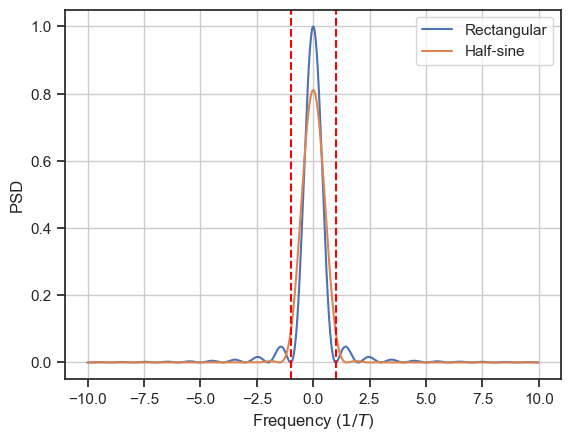

In [4]:
Es = 1
T = 1
# make a frequency grid; 1024 points between -fmax and fmax
fmax = 10/T
ff = np.arange(-fmax, fmax, 2*fmax/1024)

plt.plot(ff, np.abs(FT_rect_pulse(ff, 1))**2, label='Rectangular')
plt.plot(ff, np.abs(FT_half_sine_pulse(ff, 1))**2, label='Half-sine')

plt.grid()
plt.xlabel('Frequency ($1/T$)')
plt.ylabel('PSD')

plt.axvline(T, color='red', linestyle='--')
plt.axvline(-T, color='red', linestyle='--')

plt.legend()

plt.show()

#### Observations:

* The two spectra are very similar:
  + the power is concentrated in the *main lobe* between $-1/T$ and $1/T$.
  * outside the main lobe the power decays for frequencies away from the center

* Differences include:
  + the spectrum of the rectangular pulse is slightly taller and narrower 
  + the side lobes of the half-sine pulse decay more quickly

* Details of the side-lobe decay are difficult to discern: **plot spectra on a logarithmic scale (in dB)**

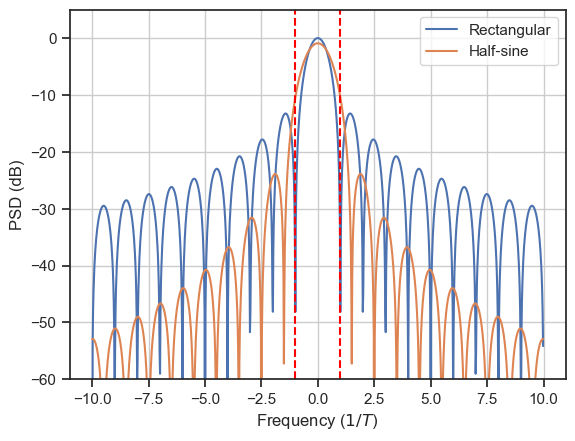

In [5]:
plt.plot(ff, 10*np.log10(np.abs(FT_rect_pulse(ff, 1))**2), label='Rectangular')
plt.plot(ff, 10*np.log10(np.abs(FT_half_sine_pulse(ff, 1))**2), label='Half-sine')

plt.grid()
plt.xlabel('Frequency ($1/T$)')
plt.ylabel('PSD (dB)')

plt.axvline(T, color='red', linestyle='--')
plt.axvline(-T, color='red', linestyle='--')

plt.legend()
plt.ylim(-60, 5)

plt.show()

* On the logarithmic scale, it is very clear that the side-lobes of the half-sine pulse decay much more quickly.
 + for the rectangular pulse, side-lobes decay like $1/|f|$
 + for the half-sine pulse, decay is proprtional to $1/|f|^2$.

* This is an import difference!
  * assume that out-of-band emissions must be 40dB lower than the peak of the PSD
  * the half-sine pulse, meets this requirement for $|f| >5/T$.
  * the rectangular pulse does not reach this level for the frequencies shown here.

* Let's look at the center of the PSD more closely.

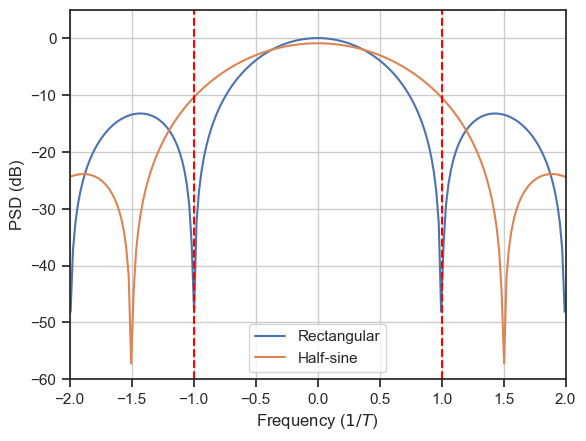

In [6]:
plt.plot(ff, 10*np.log10(np.abs(FT_rect_pulse(ff, 1))**2), label='Rectangular')
plt.plot(ff, 10*np.log10(np.abs(FT_half_sine_pulse(ff, 1))**2), label='Half-sine')

plt.grid()
plt.xlabel('Frequency ($1/T$)')
plt.ylabel('PSD (dB)')

plt.axvline(T, color='red', linestyle='--')
plt.axvline(-T, color='red', linestyle='--')

plt.legend()
plt.ylim(-60, 5)
plt.xlim(-2/T, 2/T)

plt.show()

* The width of the mainlobe for the rectangular pulse is $2/T$; from $-1/T$ to $1/T$.
    + this corresponds to the first zeros of $\text{sinc}(\pi fT)$
* The width of the mainlobe for the half-sine pulse is $3/T$; from $-1.5/T$ to $1.5/T$.
    + this corresponds to the zeros of $\cos(\pi fT)$ for $|f| > 1/(2T)$
    + Recall that for $|f| = 1/(2T)$, the Fourier transform is not zero.

## Measures of Bandwidth

* Being able to plot the PSD provides a lot of insight; key questions are
  + how wide is the main lobe?
  + how quickly do the side-lobes decay?
  + how well is power concentrated near $f=0$?
* It would be nice to have a single number that measures the bandwidth of the signal accurately.
  + **one-sided** bandwidth: measures bandwidth only for positive frequencies
  + **two-sided** bandwidth: measures bandwidth using positive and negative frequencies
    - two-sided bandwidth is always two times the one-sided bandwidth
    - two-sided bandwidth is relevant for passband signal (in wireless communications)
    - unless otherwise stated, we will measure two-sided bandwidth

### 3dB Bandwidth

* 3dB bandwidth is measured relative to the peak of the PSD $S(f)$.
* it measures the range of frequencies such that $S(F) \geq 0.5 \cdot \text{max}(S(f))$
* **Obvious short-coming:** does not consider side-lobe decay

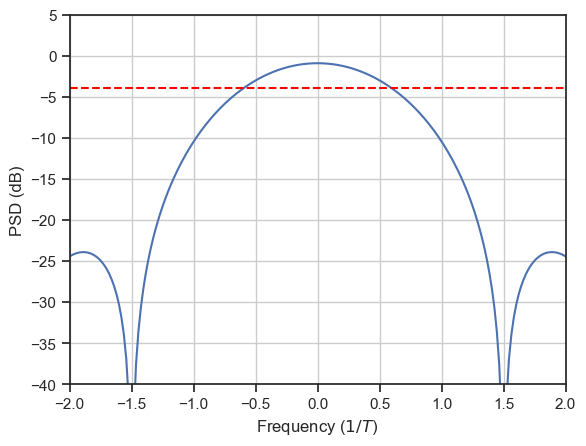

In [7]:
plt.plot(ff, 10*np.log10(np.abs(FT_half_sine_pulse(ff, 1))**2), label='Half-sine')

plt.grid()
plt.xlabel('Frequency ($1/T$)')
plt.ylabel('PSD (dB)')

plt.axhline(10*np.log10(0.5*np.max(np.abs(FT_half_sine_pulse(ff, 1))**2)), color='red', linestyle='--')

plt.ylim(-40, 5)
plt.xlim(-2/T, 2/T)

plt.show()

In [8]:
def bandwidth_3dB(ff, SS):
    """find the 3dB bandwidth of the spectrum SS"""

    # find the peak of the PSD
    peak = np.max(SS)

    # find the location spectrum value closest to 0.5 * peak
    loc = np.argmin(np.abs(SS - 0.5*peak))

    # ff[loc] is either a positive or negative frequency where S(f) = 0.*peak
    # 3dB bandwidth is twice the absolute value of this quantity
    return 2 * abs(ff[loc])

In [9]:
# make a frequency grid; 1024 points between -fmax and fmax
fmax = 16/T
ff = np.arange(-fmax, fmax, 2*fmax/4096)
S_hs = np.abs(FT_half_sine_pulse(ff, T))**2
S_r = np.abs(FT_rect_pulse(ff, T))**2

print(f"The 3dB bandwidth of the half-sine pulse is {bandwidth_3dB(ff, S_hs):4.2f} * 1/T")
print(f"The 3dB bandwidth of the rectangular pulse is {bandwidth_3dB(ff, S_r):4.2f} * 1/T")


The 3dB bandwidth of the half-sine pulse is 1.19 * 1/T
The 3dB bandwidth of the rectangular pulse is 0.89 * 1/T


### Zero-zero Bandwidth

* zero-to-zero bandwidth measure the width between the zeros of the spectrum that are closest to $f = 0$.
* This measure also does not consider sidelobes
* Also, not all pulses have zeros in their Fourier transform

In [10]:
def bandwidth_zz(ff, SS):
    """find the zero-to-zero bandwidth of the spectrum SS"""

    # find the location od  the peak of the PSD
    loc = np.argmax(SS)
    peak = SS[loc]

    # search for the first time, we get close to zero
    while(SS[loc] > 1e-4 * peak):
        loc += 1

    # ff[loc] is either a positive or negative frequency where S(f) = 0.*peak
    # 3dB bandwidth is twice the absolute value of this quantity
    return 2 * abs(ff[loc])

In [11]:
print(f"The zero-to-zero bandwidth of the half-sine pulse is {bandwidth_zz(ff, S_hs):4.1f} * 1/T")
print(f"The zero-to-zero bandwidth of the rectangulr pulse is {bandwidth_zz(ff, S_r):4.1f} * 1/T")


The zero-to-zero bandwidth of the half-sine pulse is  3.0 * 1/T
The zero-to-zero bandwidth of the rectangulr pulse is  2.0 * 1/T


### $\alpha$% Containment bandwidth

* the containment bandwidth $B_{\alpha}$ is a more comprehensive measure of bandwidth.
* It measure what range of frequencies contain $\alpha$ percent of the total power
* It is defined as
$$
    \int_{-B_{\alpha}/2}^{B_{\alpha}/2} S(f) df = \alpha \cdot \int_{-\infty}^{\infty} S(f) df = P.
$$
* This measure includes both the main lobe and the sidelobes
* it must be computed numerically.

In [12]:
def bandwidth_containment(ff, SS, alpha):
    """find the alpha containment bandwidth bandwidth of the spectrum SS"""
    # total power
    P = np.sum(SS)

    # find the location od  the peak of the PSD
    loc = np.argmax(SS)
    peak = SS[loc]

    acc = peak/2
    loc += 1
    # accumulate power untile we get to alpha*P
    while(acc < alpha * P/2):
        acc += SS[loc]
        loc += 1

    # ff[loc] is either a positive or negative frequency where S(f) = 0.*peak
    # 3dB bandwidth is twice the absolute value of this quantity
    return 2 * abs(ff[loc])

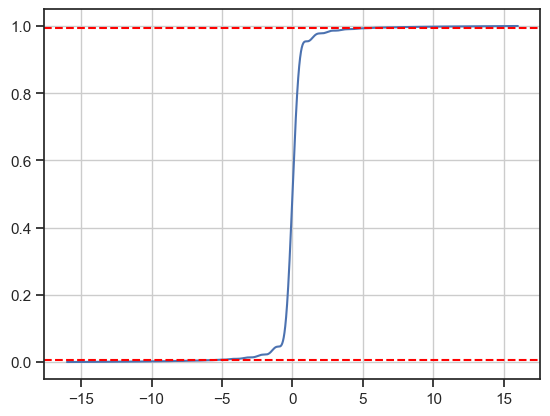

In [13]:
plt.plot(ff, np.cumsum(S_r)/sum(S_r))
plt.grid()
plt.axhline(0.995, color='red', linestyle='--')
plt.axhline(0.005, color='red', linestyle='--')


In [14]:
print(f"The 99% containment bandwidth of the half-sine pulse is {bandwidth_containment(ff, S_hs, 0.99):4.2f} * 1/T")
print(f"The 99% containment bandwidth of the rectangulr pulse is {bandwidth_containment(ff, S_r, 0.99):4.2f} * 1/T")


The 99% containment bandwidth of the half-sine pulse is 2.38 * 1/T
The 99% containment bandwidth of the rectangulr pulse is 12.73 * 1/T


### Computing the Fourier Transform numerically

We can show that the Fourier Transform
$$
P(f) = \int p(t) e^{-j2\pi ft}dt
$$
can be approximated from samples $p[n]$ of $p(t)$ at rate $f_s$
$$
P(f) \approx \frac{1}{f_s} \sum_n p(n/f_s) e^{-j2\pi \frac{nf}{f_s}}.
$$

Further, we compute the Fourier Transform only at a discrete set of frequencies $f = k \frac{f_s}{N}$ for $-N/2 \leq k < N/2$,
$$
P(kf_s/N) \approx \frac{1}{f_s} \sum_n p(n/f_s) e^{-j2\pi \frac{kn}{N}},
$$
where the number of frequency samples $N$ must satisfy:
* $N \geq  \text{length}(p[n])$; if $p[n]$ is shorter than $N$, $p[n]$ is padded with zeros to length $N$
* Frequency resolution $f_s/N \ll \frac{1}{T}$, i.e., $N \gg fsT$ 
* $N$ should be a power of 2 to allow for a fast FFT algorithm.

In [15]:
def numerical_FT(pp, fs, N):
    """compute Fourier transform numerically"""

    assert len(pp) <= N, "pukse is too long"

    # zero-pad pp
    padded = np.zeros(N, dtype=complex)
    padded[:len(pp)] = pp

    # compute DFT (using FFT)
    PP = np.fft.fftshift(np.fft.fft(padded)) / fs

    return PP

In [16]:
## rectangular pulse
T = 1
fs = 32
fsT = int(fs*T)

N_FFT = 1024
pp = np.ones(fsT)
PP = numerical_FT(pp, fs, N=N_FFT)

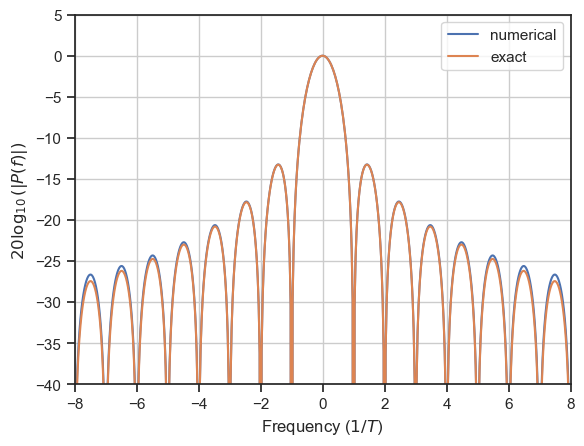

In [17]:
ff = np.arange(-N_FFT/2, N_FFT/2)/N_FFT*fs
Pt = FT_rect_pulse(ff, T)

plt.plot(ff, 
         20*np.log10(np.abs(PP+1e-8)), label="numerical")
plt.plot(ff, 
         20*np.log10(np.abs(Pt)), label='exact')
plt.xlabel('Frequency ($1/T$)')
plt.ylabel('$20\log_{10}(|P(f)|)$')
plt.legend()
plt.grid()

plt.ylim(-40, 5)
plt.xlim(-fs/4, fs/4)

plt.show()

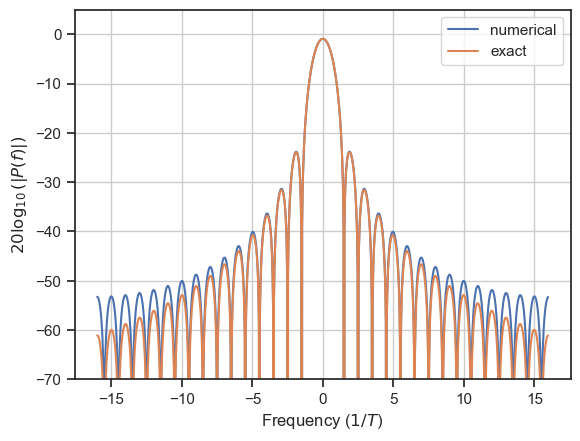

In [18]:
## half-sine pulse
pp_hs = np.sqrt(2/T) * np.sin(np.pi*np.arange(fsT)/fsT)
PP_hs = numerical_FT(pp_hs, fs, N=N_FFT)

# exact
PP_hs_t = FT_half_sine_pulse(ff, T)

plt.plot(ff, 
         20*np.log10(np.abs(PP_hs)), label="numerical")
plt.plot(ff, 
         20*np.log10(np.abs(PP_hs_t)), label='exact')
plt.xlabel('Frequency ($1/T$)')
plt.ylabel('$20\log_{10}(|P(f)|)$')
plt.legend()
plt.grid()

plt.ylim(-70, 5)

plt.show()


(-5.0, 5.0)

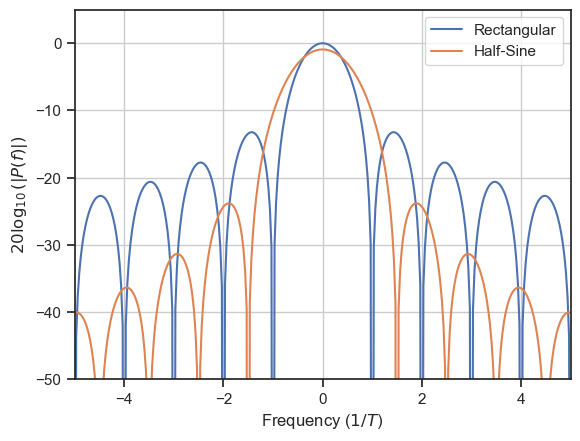

In [19]:
## Comparison of rectaangular and half_sine spectra
plt.plot(ff, 
         20*np.log10(np.abs(PP+1e-8)), label="Rectangular")
plt.plot(ff, 
         20*np.log10(np.abs(PP_hs)), label='Half-Sine')
plt.xlabel('Frequency ($1/T$)')
plt.ylabel('$20\log_{10}(|P(f)|)$')
plt.legend()
plt.grid()

plt.ylim(-50, 5)
plt.xlim(-5,5)